In [42]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [43]:
def benchmark(X, Y):
    return (X * np.sin(X)) + (Y * np.sin(Y))


In [44]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [45]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [46]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 18, pretrain_n)
Y = np.random.uniform(-5, 18, pretrain_n)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [47]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [48]:
df

x          y          z
0   4.591506   4.641474  -9.178355
1  11.567463  10.760049 -20.215970
2  -4.997369  -0.297598  -4.729201
3   1.953649  15.196701   9.125555
4  -1.624615  -4.370085  -2.404303
5  -2.876212  10.420753  -7.934456
6  -0.716015   4.598010  -4.114257
7   2.947897   7.849866   8.455922
8   4.125652  -1.771100  -1.685894
9   7.392785  -0.443666   6.783145

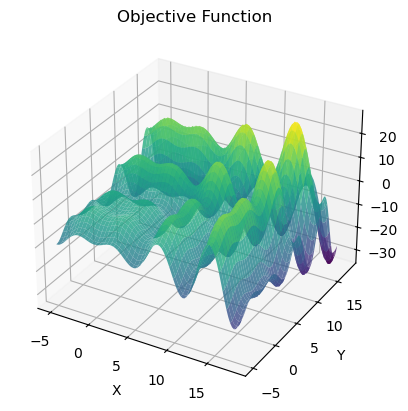

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 18, 100)
y_range = np.linspace(-5, 18, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [50]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [51]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 14.28, "Y":  14.28, "Z": benchmark(14.28,  14.28)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y          Z
0  14.28  14.28  28.269165

In [52]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 18, 100)
    y_range = np.linspace(-5, 18, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 90
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 18], [-5, 18]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # # Train the model with the best hyperparameters on the entire dataset
    # best_model = NN_model(
    #     num_layers=result.x[0],
    #     num_units=result.x[1],
    #     learning_rate=result.x[2],
    #     dropout_rate=result.x[3]
    # )

    # # Standardize the Dataset of Simulation Responses
    # scaler_x = StandardScaler().fit(sim_df[['x', 'y']])
    # X_scaled = scaler_x.transform(sim_df[['x', 'y']])

    # # Train the best model on the combined standardized dataset
    # best_model.fit(X_scaled, sim_df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)
    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=6,
        num_units=300,
        learning_rate=0.01,
        dropout_rate=0.2
    )

    # Train the best model on the initial dataset
    best_model.fit(sim_df[['x','y']], sim_df[['sim_z']], epochs=500, batch_size=128, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 18)]
    y_range = [(-5, 18)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy)  # Get mean & uncertainty
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        for i in range(sample_size - 1):
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            output = np.vstack((output, xy))  # Stack valid samples

        return output  # Returns an array of shape (sample_size, 2)

    # Use Metropolis-Hastings to sample new experimental points
    X_mh = mh_sampler(sig=5, sample_size=pretrain_n, burn_in=50, lag=20)

    # Convert MH samples to a DataFrame
    physical_test_points = pd.DataFrame(X_mh, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 2.73047019 -3.09689622]


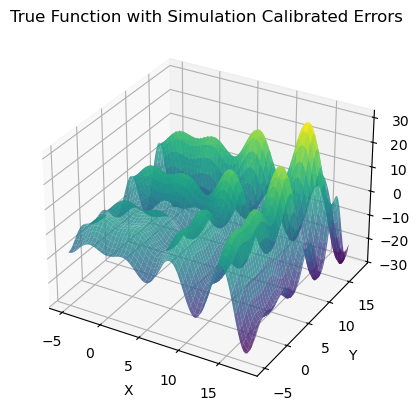

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 121.0980
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 783.8894
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 140.3393
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 122.4773
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 120.1645
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 118.4887
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 118.0163
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 119.4425
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 119.9341
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 117.2352
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 116.8161
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 118.8800
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 114.1425
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 113.3870
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 

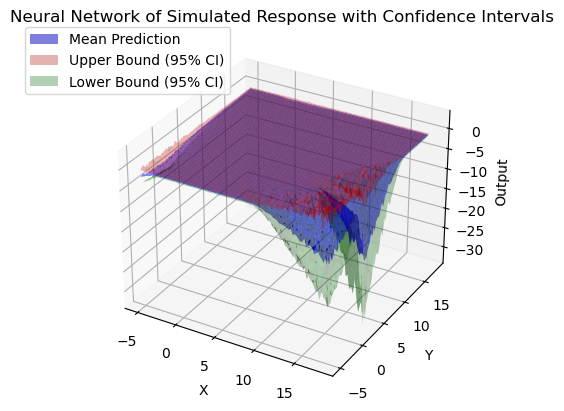

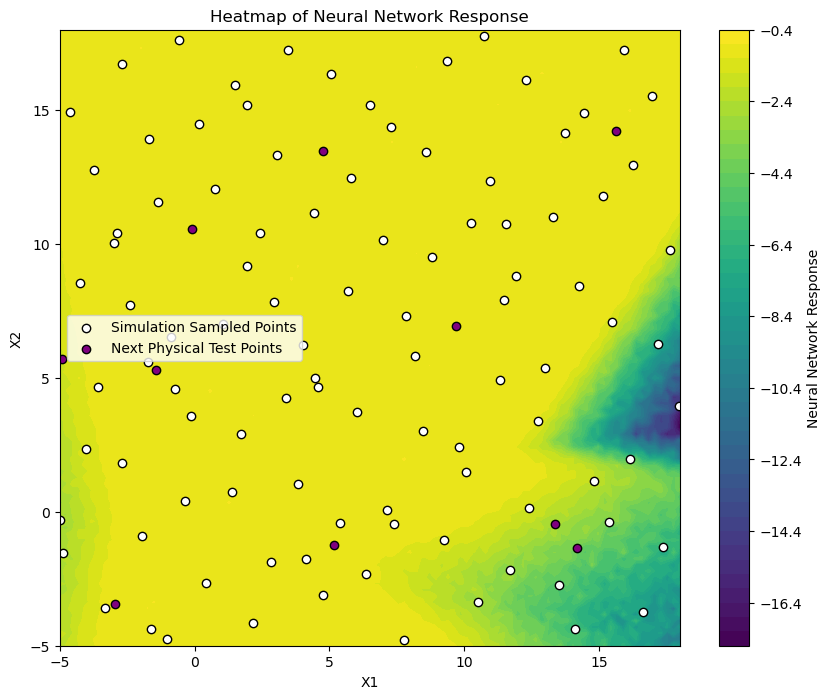

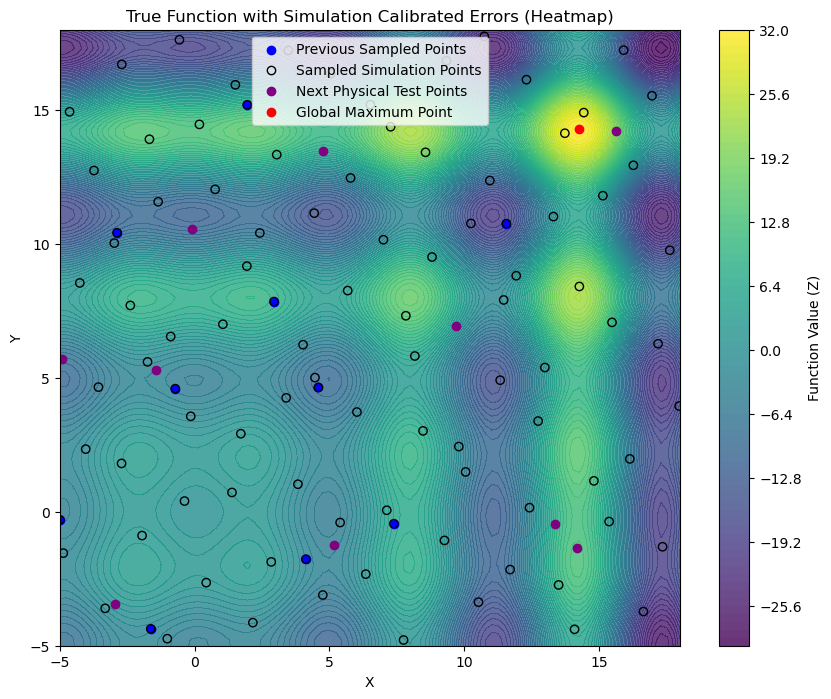

            x          y          z        a         b      sim_z      diff
0    4.591506   4.641474  -9.178355  2.73047 -3.096896  -9.561388  0.383033
1   11.567463  10.760049 -20.215970  2.73047 -3.096896 -18.981988 -1.233982
2   -4.997369  -0.297598  -4.729201  2.73047 -3.096896  -3.511473 -1.217728
3    1.953649  15.196701   9.125555  2.73047 -3.096896   9.891099 -0.765544
4   -1.624615  -4.370085  -2.404303  2.73047 -3.096896  -1.881428 -0.522875
5   -2.876212  10.420753  -7.934456  2.73047 -3.096896  -8.135435  0.200979
6   -0.716015   4.598010  -4.114257  2.73047 -3.096896  -4.002058 -0.112200
7    2.947897   7.849866   8.455922  2.73047 -3.096896   8.504247 -0.048325
8    4.125652  -1.771100  -1.685894  2.73047 -3.096896  -2.840597  1.154703
9    7.392785  -0.443666   6.783145  2.73047 -3.096896   5.045118  1.738027
10   4.751910  13.468385   5.866214  2.73047 -3.096896   6.259146 -0.392932
11  13.371103  -0.460498   9.873859  2.73047 -3.096896   7.959653  1.914206
12  15.62909

In [53]:
df = perform_iteration(df)
print(df)


[ 2.94810967 -3.20508123]


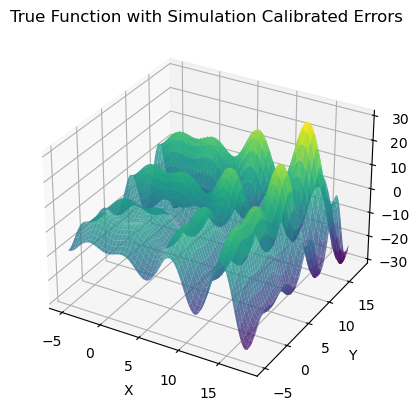

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 115.1379
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 408.5797
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 134.7057
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 115.5612
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 114.1743
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 112.2249
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 112.2765
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 109.9288
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 113.2974
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 110.8050
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 110.4583
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 108.1030
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 109.1710
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 108.0894
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 

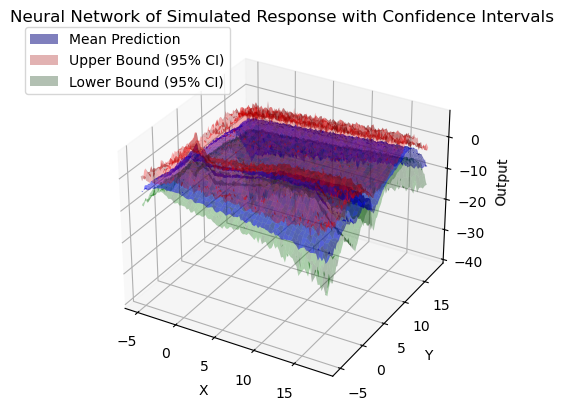

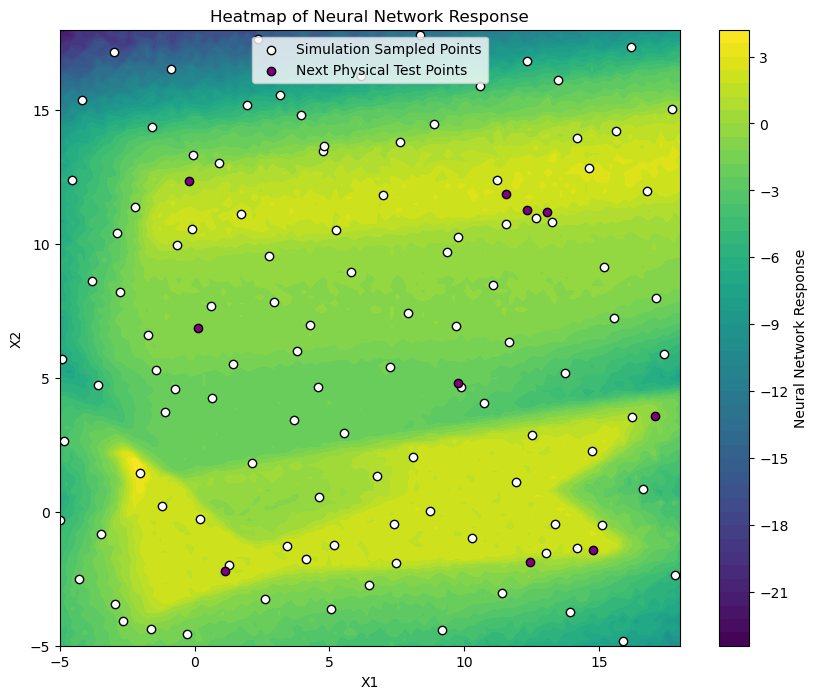

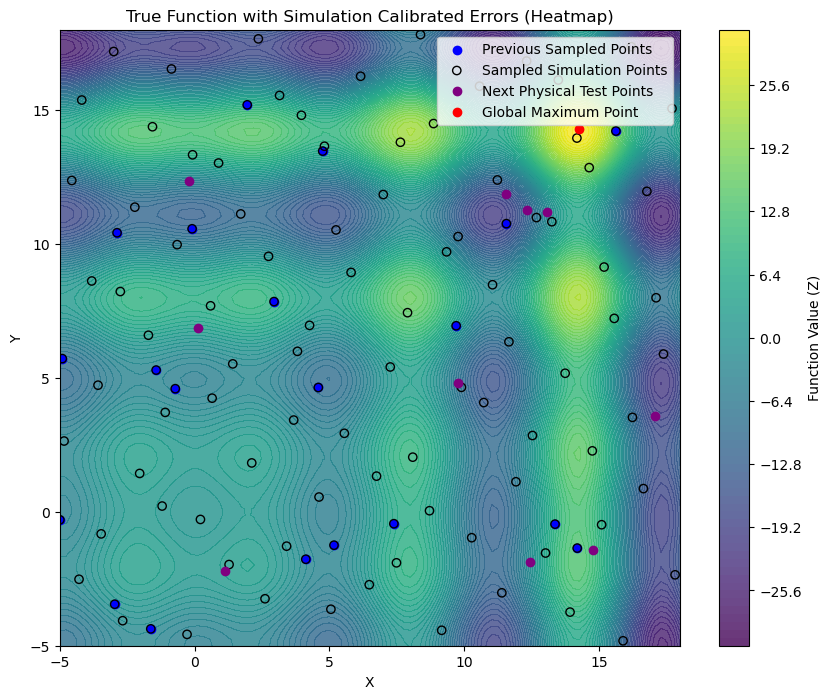

In [54]:
df = perform_iteration(df)

[ 3.38464598 -3.27579138]


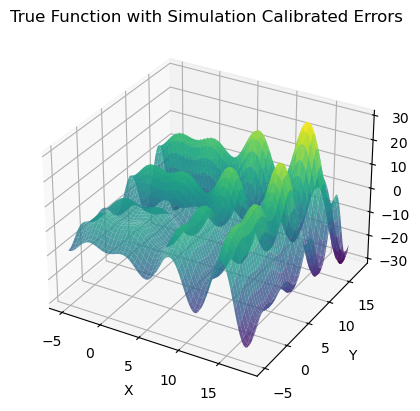

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 452.2396
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 916.0439
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 473.0240
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 460.2232
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 451.5939
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 449.0718
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 444.8206
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 438.1823
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 424.1181
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 424.1066
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 453.4502
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 436.8012
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 433.6967
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 430.1773
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 

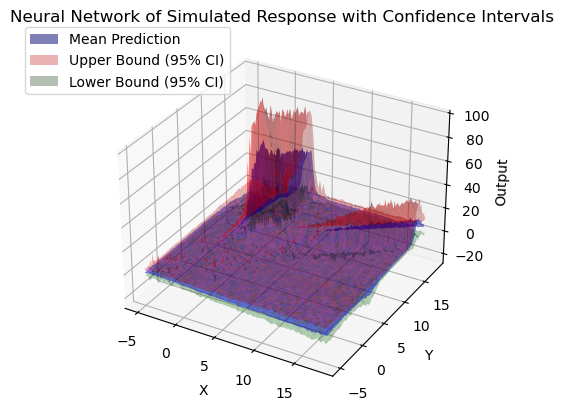

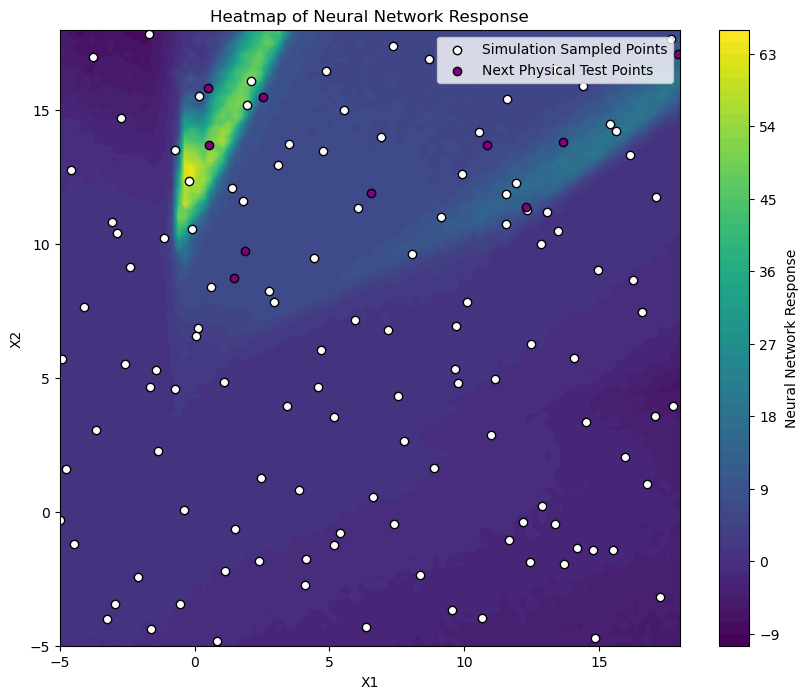

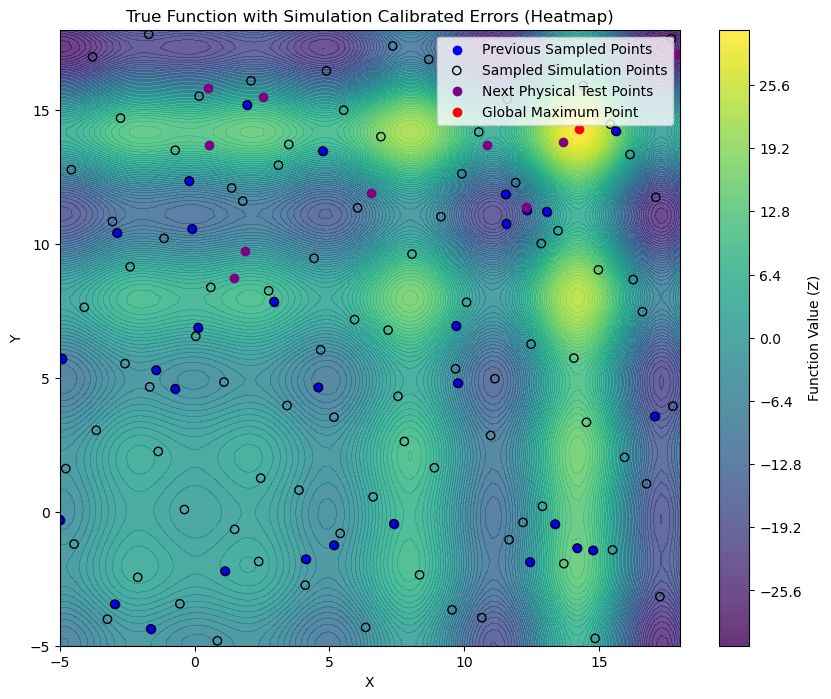

            x          y          z         a         b       sim_z  \
0    4.591506   4.641474  -9.178355  3.384646 -3.275791   -4.555512   
1   11.567463  10.760049 -20.215970  3.384646 -3.275791   21.343075   
2   -4.997369  -0.297598  -4.729201  3.384646 -3.275791    1.614706   
3    1.953649  15.196701   9.125555  3.384646 -3.275791  111.881724   
4   -1.624615  -4.370085  -2.404303  3.384646 -3.275791    8.364226   
5   -2.876212  10.420753  -7.934456  3.384646 -3.275791   43.687455   
6   -0.716015   4.598010  -4.114257  3.384646 -3.275791    6.237196   
7    2.947897   7.849866   8.455922  3.384646 -3.275791   33.234005   
8    4.125652  -1.771100  -1.685894  3.384646 -3.275791   -5.648174   
9    7.392785  -0.443666   6.783145  3.384646 -3.275791   -2.419169   
10   4.751910  13.468385   5.866214  3.384646 -3.275791   83.642212   
11  13.371103  -0.460498   9.873859  3.384646 -3.275791   -6.928095   
12  15.629092  14.216614  15.414225  3.384646 -3.275791   93.745444   
13  -1

In [55]:
df = perform_iteration(df)
print(df)

[ 2.71447787 -3.22487219]


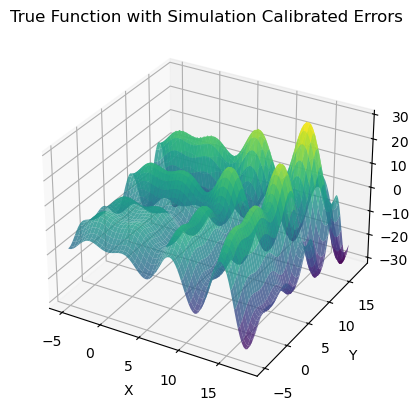

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 225.7205
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 162.5947 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 177.7601 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 164.4023 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 161.7269 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 181.1254 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 176.7950 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 164.2951 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 154.0764 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 162.7177 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 157.4165 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.0816 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 167.1942 
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158.5670 
Epoch 15/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

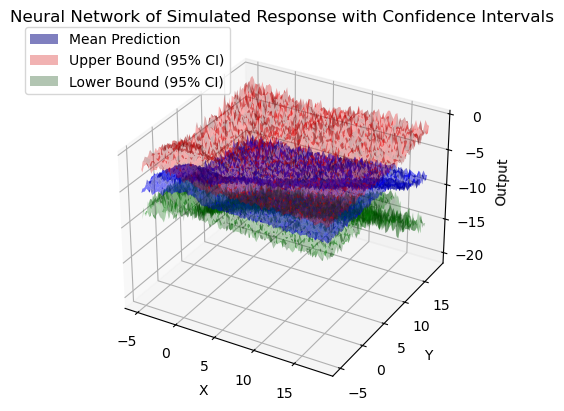

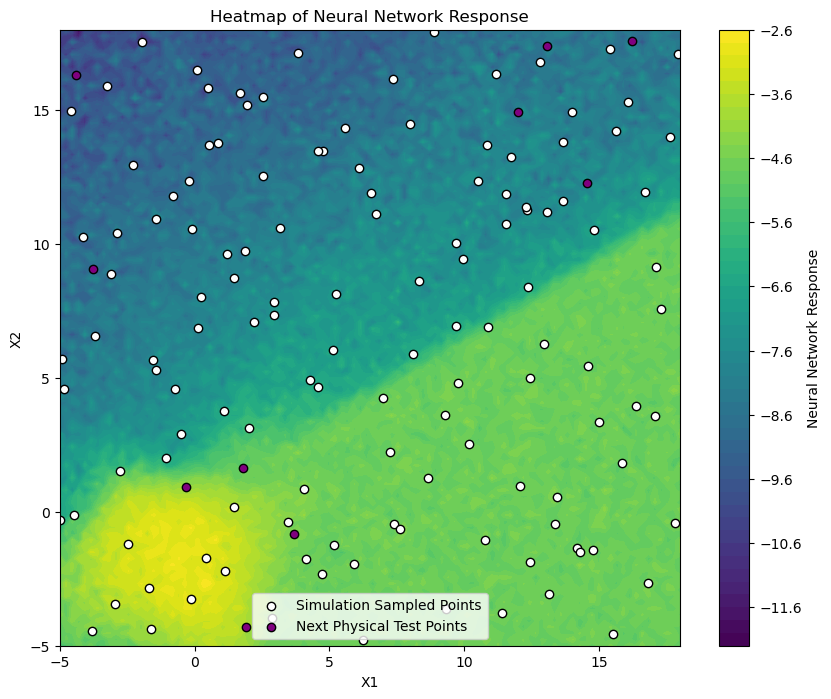

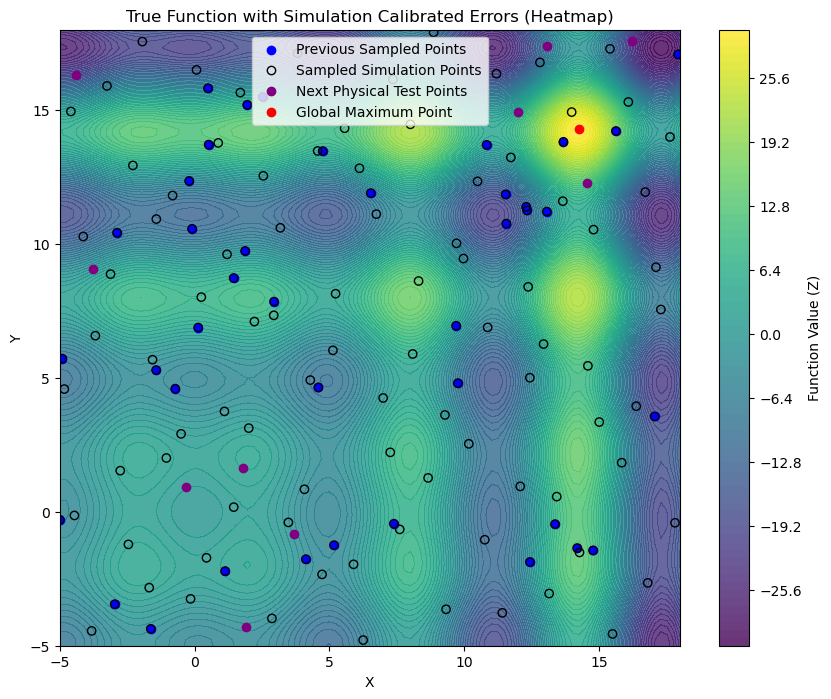

            x          y          z         a         b      sim_z       diff
0    4.591506   4.641474  -9.178355  2.714478 -3.224872  -9.857972   0.679617
1   11.567463  10.760049 -20.215970  2.714478 -3.224872 -29.223003   9.007033
2   -4.997369  -0.297598  -4.729201  2.714478 -3.224872  -6.855037   2.125835
3    1.953649  15.196701   9.125555  2.714478 -3.224872 -24.543631  33.669187
4   -1.624615  -4.370085  -2.404303  2.714478 -3.224872  -5.926176   3.521873
5   -2.876212  10.420753  -7.934456  2.714478 -3.224872 -26.853012  18.918556
6   -0.716015   4.598010  -4.114257  2.714478 -3.224872  -7.759804   3.645547
7    2.947897   7.849866   8.455922  2.714478 -3.224872   0.917917   7.538004
8    4.125652  -1.771100  -1.685894  2.714478 -3.224872  -0.599522  -1.086372
9    7.392785  -0.443666   6.783145  2.714478 -3.224872   9.909722  -3.126578
10   4.751910  13.468385   5.866214  2.714478 -3.224872 -18.098895  23.965109
11  13.371103  -0.460498   9.873859  2.714478 -3.224872  15.4586

In [56]:
df = perform_iteration(df)
print(df)

[ 1.66928096 -3.17424741]


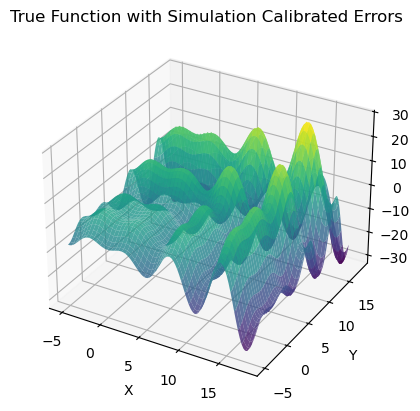

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1018.3464
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 594.6306 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 651.5410 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 543.0465 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 466.8352 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 430.5841 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 445.7791 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 531.7161 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 544.7656 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 504.2191 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 459.6617 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 464.2524 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 447.6442 
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 477.0887 
Epoch 15/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

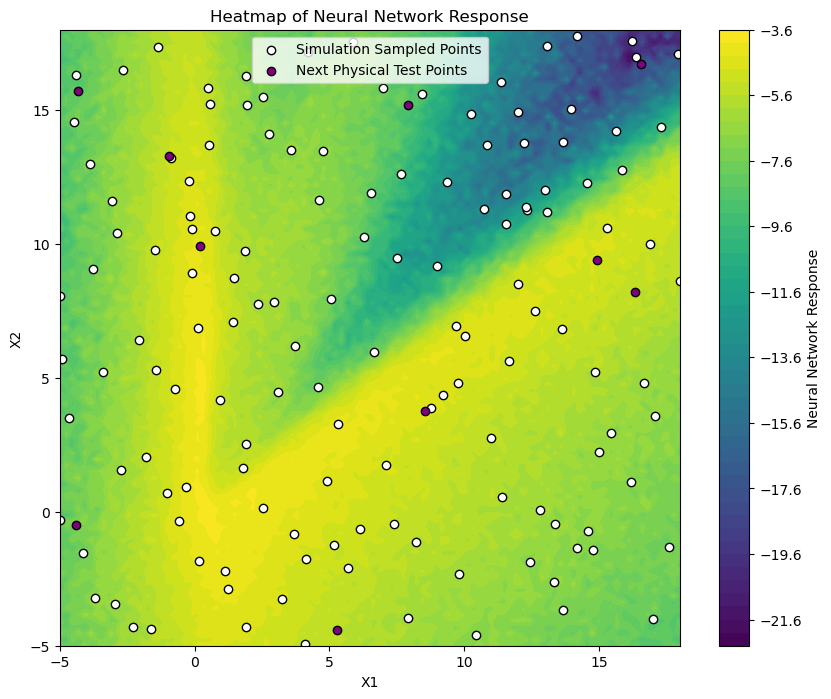

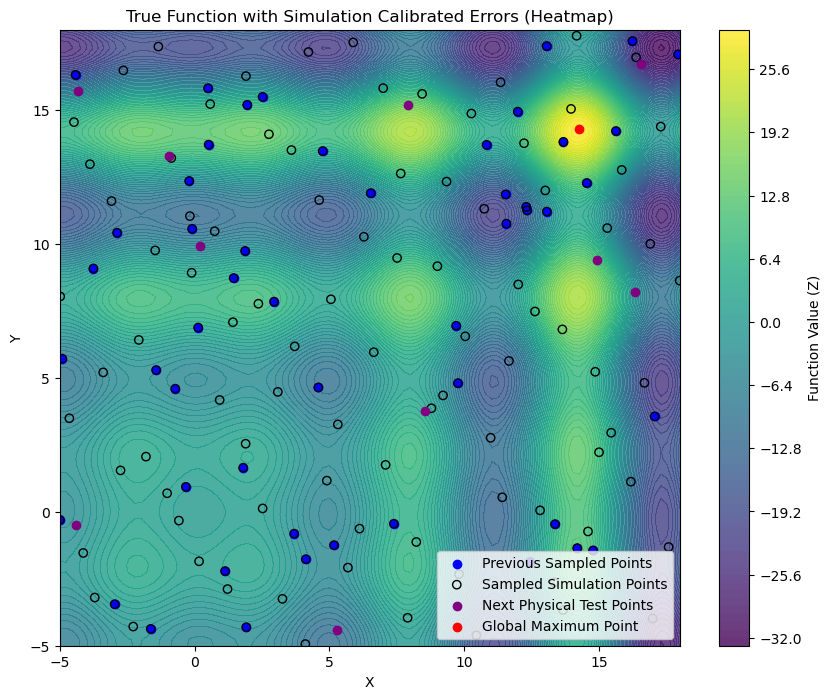

            x          y          z         a         b       sim_z       diff
0    4.591506   4.641474  -9.178355  1.669281 -3.174247  -16.869477   7.691122
1   11.567463  10.760049 -20.215970  1.669281 -3.174247  -53.331149  33.115179
2   -4.997369  -0.297598  -4.729201  1.669281 -3.174247   -1.666527  -3.062675
3    1.953649  15.196701   9.125555  1.669281 -3.174247  -50.710124  59.835680
4   -1.624615  -4.370085  -2.404303  1.669281 -3.174247   -6.227366   3.823064
5   -2.876212  10.420753  -7.934456  1.669281 -3.174247  -35.211936  27.277480
6   -0.716015   4.598010  -4.114257  1.669281 -3.174247   -9.218175   5.103918
7    2.947897   7.849866   8.455922  1.669281 -3.174247   -8.577299  17.033220
8    4.125652  -1.771100  -1.685894  1.669281 -3.174247   -5.202757   3.516863
9    7.392785  -0.443666   6.783145  1.669281 -3.174247    2.221405   4.561739
10   4.751910  13.468385   5.866214  1.669281 -3.174247  -41.990966  47.857180
11  13.371103  -0.460498   9.873859  1.669281 -3.174

In [57]:
df = perform_iteration(df)
print(df)